In [369]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
%matplotlib inline
import matplotlib.patheffects as pe

path = '/Users/chrislam/Desktop/mastrangelo/'


In [370]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

k = pd.Series([833, 134, 38, 15, 5, 0])

In [371]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

Read in and process data (pad and create zero bins)

In [372]:
truth = pd.read_csv(path+'data/collect_asymmetric.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.read_csv(path+'data/collect_recovery_asymmetric.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = recovery.loc[~(np.round(recovery.cs, -7) == 1.6e8)] # defective simulations need replacing
recovery_redo = pd.read_csv(path+'data/collect_recovery_asymmetric_redo.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.concat([recovery, recovery_redo])


In [171]:
np.sort(recovery.cs.unique())

array([1.00000000e+08, 1.58489319e+08, 2.51188643e+08, 3.98107171e+08,
       6.30957344e+08, 1.00000000e+09, 1.58489319e+09, 2.51188643e+09,
       3.98107171e+09, 6.30957344e+09, 1.00000000e+10])

Prepare machinery for injection-recovery experiments

In [173]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-1,0,6)[gi_m] 
    cube[1] = np.linspace(0,1,11)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [174]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

#### Quality control

With so many records, some of them get corrupted. There are several ways we can deal with this, but since each model has 30 random samples, a corrupted record will simply be dropped. Therefore, later on, rather than summing to marginalize the log likelihoods, we take the mean. 

In [ ]:
# retrieve indices of rows that somehow got padded with many extra bins
long_indices = recovery.loc[recovery['transit_multiplicities'].str.len() > 6]['transit_multiplicities'].index

# drop these rows
recovery = recovery.drop(long_indices)

In [ ]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

In [ ]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


What would it look like to take the logL of something that's sqrt(N) deviated from the ground truth, where N is the number of systems in each bin? 

Answer: this is $\Delta$ logL of 3 different from the perfect case of comparing the ground truth to itself.

In [ ]:
better_loglike(np.array([9900, 804, 122, 32, 11, 3, 0]), np.array([1e4, 833, 134, 38, 15, 5, 0]))

In [175]:
def build_models(x, m, b, c, f): # adapted from Ballard et al in prep, log version
    """ 
    Calculate P(intact) as a function of time, in order to visualize sculpting models.

    Input:
    - x: grid of ages [log yrs]
    - m: sculpting law slope [dex]
    - b: sculpting law initial intact probability, out of planet-hosting stars
    - c: sculpting law turnoff time [log yrs]
    - f: fraction of planet-hosting stars

    Output:
    - y: grid of P(intacts)

    """

    # x-axis before cutoff
    x1 = x[x<c]
    x2 = x[x>=c]
    
    # first piece, before cutoff
    y1 = (b + m * (np.log10(x1) - 8)) * f
    
    # second piece, after cutoff
    y2 = np.ones(len(x2)) * (b + m * (np.log10(c) - 8)) * f
    
    y = np.concatenate((y1, y2))
    
    # flatten out at zero
    y = np.where(y < 0, 0, y)
    
    return y

In [176]:
def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2] # // is floor division

#### Model 2: m = -1, b = 0.5, c = 4e9, f = 0.3 (heavy sculpting model)

In [338]:
tm_fiducial = truth.loc[(truth.ms == -1.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

692    [591.3, 31.2, 0.0, 0.0, 0.0, 0.0]
Name: transit_multiplicities, dtype: object

In [339]:
test_recovery = recovery.loc[(recovery.ms == -1.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]


Let's quickly check their transit yields to see whether they make sense.

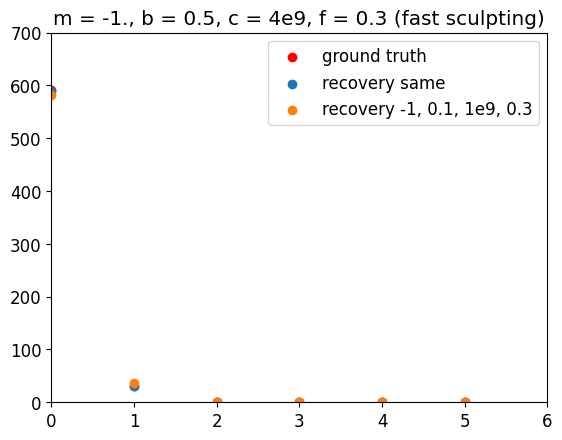

In [19]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[20760].transit_multiplicities)), recovery.iloc[20760].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

This makes sense: the yields between higher b but short-lived sculpting and lower b but longer-lived sculpting are similar.

In [340]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median/max logL for each model
                    median_logL = np.max(logLs) # np.median(logLs)
                    median_arg = np.argmax(logLs) # argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                    
                if ((np.round(cube[0],1)==-1.) & (np.round(cube[1],1)==0.5) & (np.round(cube[2],-8)==4e9) & (np.round(f,1)==0.3)):
                    print(len(tm_recovery))
                    print(np.max(logLs) - np.min(logLs))
                

30
1.1480830720248942


In [341]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'injection_transit_multiplicities': all_transit_multiplicities, 
                            'logL': all_logLs})
model_logLs

,m,b,c,f,injection_transit_multiplicities,logL
0,-1.0,0.0,1.000000e+08,0.1,"[207.4, 10.5, 0.0, 0.0, 0.0, 0.0]",-255.619955
1,-1.0,0.0,1.000000e+08,0.2,"[414.8, 21.0, 0.0, 0.0, 0.0, 0.0]",-42.035835
2,-1.0,0.0,1.000000e+08,0.3,"[590.4, 30.9, 0.0, 0.0, 0.0, 0.0]",-6.754197
3,-1.0,0.0,1.000000e+08,0.4,"[734.0, 39.2, 0.0, 0.0, 0.0, 0.0]",-22.499888
4,-1.0,0.0,1.000000e+08,0.5,"[917.5, 49.0, 0.0, 0.0, 0.0, 0.0]",-76.893028
...,...,...,...,...,...,...
7255,0.0,1.0,1.000000e+10,0.6,"[1404.0, 680.4, 340.2, 132.6, 42.6, 6.6]",-1383.154599
7256,0.0,1.0,1.000000e+10,0.7,"[1638.0, 793.8, 396.9, 154.7, 49.6999999999999...",-1721.595801
7257,0.0,1.0,1.000000e+10,0.8,"[1872.0, 907.2, 453.6, 176.8, 56.8000000000000...",-2072.872509
7258,0.0,1.0,1.000000e+10,0.9,"[2106.0, 1020.6, 510.3, 198.9, 63.9, 9.9]",-2433.952569


### Note that while these logLs take f into account, they do not take the zero-bin into account. analyze.ipynb has machinery to handle that, and we can do this injection-recovery routine with those logLs instead, if we want. 

#### What is the $\Delta$ logL between the very best model and the ground truth?

Identify best and good models

In [22]:
x = np.logspace(8, 10, 1000)

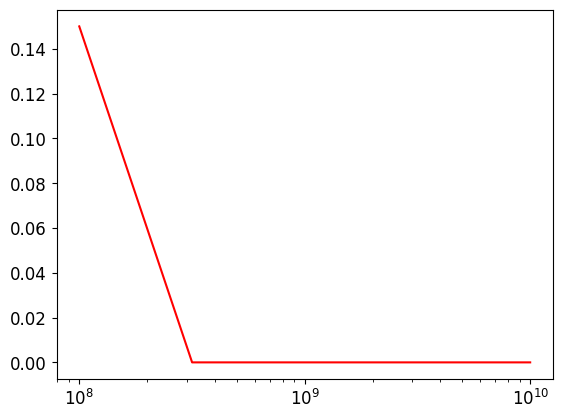

In [23]:
ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
plt.xscale('log')


In [342]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == -1.) & (np.round(recovery.bs,1) == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)].logLs)
print("delta logL: ", delta_logL)
print("delta logL: ", np.abs(ground_truth.logL - best_logL))
delta_logL = 15.

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f   injection_transit_multiplicities     logL
362  -1.0  0.3  3.981072e+08  0.3  [591.3, 31.2, 0.0, 0.0, 0.0, 0.0] -6.75206
6122  0.0  0.0  2.511886e+09  0.3  [591.3, 31.2, 0.0, 0.0, 0.0, 0.0] -6.75206
Ground truth:         m    b             c    f  \
632 -1.0  0.5  3.981072e+09  0.3   

                  injection_transit_multiplicities      logL  
632  [589.1999999999999, 31.2, 0.0, 0.0, 0.0, 0.0] -6.755798  
delta logL:  13.890404293520739
delta logL:  632    0.003738
Name: logL, dtype: float64
Some models between best model and ground truth: 
      m    b            c    f   injection_transit_multiplicities      logL
2  -1.0  0.0  100000000.0  0.3  [590.4, 30.9, 0.0, 0.0, 0.0, 0.0] -6.754197
12 -1.0  0.0  158489319.0  0.3  [588.3, 30.0, 0.0, 0.0, 0.0, 0.0] -6.783382
22 -1.0  0.0  251188643.0  0.3  [594.6, 30.9, 0.0, 0.0, 0.0, 0.0] -6.762686
32 -1.0  0.0  398107171.0  0.3  [591.9, 30.9, 0.0, 0.0, 0.0, 0.0] -6.753815
42 -1.0  0.0  6309573

In [206]:
recovery.loc[(np.round(recovery.ms, 1) == -1.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
20760,-1.0,0.5,3.981072e+09,0.3,"[589.1999999999999, 31.2, 0.0, 0.0, 0.0, 0.0]","[1208.3999999999999, 107.7, 0.0, 0.0, 0.0, 0.0]",0.000013,0.299987,-280.440715,-174.943245,-345.604569
20761,-1.0,0.5,3.981072e+09,0.3,"[579.6, 38.699999999999996, 0.0, 0.0, 0.0, 0.0]","[1206.8999999999999, 116.1, 0.3, 0.0, 0.0, 0.0]",0.000009,0.299991,-263.158319,-158.435508,-336.604188
20762,-1.0,0.5,3.981072e+09,0.3,"[582.0, 35.699999999999996, 0.0, 0.0, 0.0, 0.0]","[1200.0, 115.8, 0.0, 0.0, 0.0, 0.0]",0.000004,0.299996,-269.928479,-164.507291,-340.787539
20763,-1.0,0.5,3.981072e+09,0.3,"[577.8, 36.3, 0.0, 0.0, 0.0, 0.0]","[1206.8999999999999, 107.39999999999999, 0.0, ...",0.000004,0.299996,-270.128230,-163.560698,-343.150841
20764,-1.0,0.5,3.981072e+09,0.3,"[570.6, 36.9, 0.0, 0.0, 0.0, 0.0]","[1203.8999999999999, 115.5, 0.0, 0.0, 0.0, 0.0]",0.000004,0.299996,-271.776737,-162.987739,-348.308365
20765,-1.0,0.5,3.981072e+09,0.3,"[596.6999999999999, 35.4, 0.0, 0.0, 0.0, 0.0]","[1207.5, 111.89999999999999, 0.0, 0.0, 0.0, 0.0]",0.000013,0.299987,-264.680913,-164.138080,-329.018907
20766,-1.0,0.5,3.981072e+09,0.3,"[594.0, 34.5, 0.0, 0.0, 0.0, 0.0]","[1194.8999999999999, 113.1, 0.0, 0.0, 0.0, 0.0]",0.000004,0.299996,-268.309532,-166.361300,-333.314693
20767,-1.0,0.5,3.981072e+09,0.3,"[611.1, 32.4, 0.0, 0.0, 0.0, 0.0]","[1210.2, 112.2, 0.0, 0.0, 0.0, 0.0]",0.000004,0.299996,-268.083236,-170.674808,-324.657950
20768,-1.0,0.5,3.981072e+09,0.3,"[586.8, 35.1, 0.0, 0.0, 0.0, 0.0]","[1160.1, 117.89999999999999, 0.0, 0.0, 0.0, 0.0]",0.000004,0.299996,-269.557793,-165.473709,-338.000343
20769,-1.0,0.5,3.981072e+09,0.3,"[569.4, 30.299999999999997, 0.0, 0.0, 0.0, 0.0]","[1170.0, 104.39999999999999, 0.0, 0.0, 0.0, 0.0]",0.000004,0.299996,-292.136976,-179.178502,-365.461234


Hold on: why are there multiple best models? EDIT 1: It seems like some data swapping happened when the simulations were made. So, I have to identify the real one and then drop the other rows. EDIT 2: Maybe the sure-fire way is to re-draw a simulation with my unit test script and see how close it gets to the apparently-copied data? EDIT 3: This problem went away when I went from taking the best logL per 30 draws of a model, to taking the median logL per 30 draws of a model.

In [26]:
model_logLs.iloc[1380:1390] # this is the right one

,m,b,c,f,injection_transit_multiplicities,logL
1380,-0.8,0.1,1.584893e+09,0.1,"[207.60000000000002, 10.5, 0.0, 0.0, 0.0, 0.0]",-255.250027
1381,-0.8,0.1,1.584893e+09,0.2,"[415.20000000000005, 21.0, 0.0, 0.0, 0.0, 0.0]",-41.865907
1382,-0.8,0.1,1.584893e+09,0.3,"[591.6, 31.799999999999997, 0.0, 0.0, 0.0, 0.0]",-6.757832
1383,-0.8,0.1,1.584893e+09,0.4,"[761.6, 43.2, 0.0, 0.0, 0.0, 0.0]",-29.242045
1384,-0.8,0.1,1.584893e+09,0.5,"[952.0, 54.0, 0.0, 0.0, 0.0, 0.0]",-91.535184
1385,-0.8,0.1,1.584893e+09,0.6,"[1142.3999999999999, 64.8, 0.0, 0.0, 0.0, 0.0]",-179.240015
1386,-0.8,0.1,1.584893e+09,0.7,"[1332.8, 75.6, 0.0, 0.0, 0.0, 0.0]",-284.481217
1387,-0.8,0.1,1.584893e+09,0.8,"[1523.2, 86.4, 0.0, 0.0, 0.0, 0.0]",-402.557925
1388,-0.8,0.1,1.584893e+09,0.9,"[1713.6000000000001, 97.2, 0.0, 0.0, 0.0, 0.0]",-530.437985
1389,-0.8,0.1,1.584893e+09,1.0,"[1904.0, 108.0, 0.0, 0.0, 0.0, 0.0]",-666.051064


In [27]:
model_logLs.iloc[1490:1500]

,m,b,c,f,injection_transit_multiplicities,logL
1490,-0.8,0.2,1.584893e+09,0.1,"[208.9, 12.100000000000001, 0.0, 0.0, 0.0, 0.0]",-250.033724
1491,-0.8,0.2,1.584893e+09,0.2,"[417.8, 24.200000000000003, 0.0, 0.0, 0.0, 0.0]",-39.549605
1492,-0.8,0.2,1.584893e+09,0.3,"[593.1, 32.4, 0.0, 0.0, 0.0, 0.0]",-6.777296
1493,-0.8,0.2,1.584893e+09,0.4,"[767.2, 43.2, 0.0, 0.0, 0.0, 0.0]",-30.510157
1494,-0.8,0.2,1.584893e+09,0.5,"[959.0, 54.0, 0.0, 0.0, 0.0, 0.0]",-94.203297
1495,-0.8,0.2,1.584893e+09,0.6,"[1150.8, 64.8, 0.0, 0.0, 0.0, 0.0]",-183.308127
1496,-0.8,0.2,1.584893e+09,0.7,"[1342.6, 75.6, 0.0, 0.0, 0.0, 0.0]",-289.949329
1497,-0.8,0.2,1.584893e+09,0.8,"[1534.4, 86.4, 0.0, 0.0, 0.0, 0.0]",-409.426037
1498,-0.8,0.2,1.584893e+09,0.9,"[1726.2, 97.2, 0.0, 0.0, 0.0, 0.0]",-538.706098
1499,-0.8,0.2,1.584893e+09,1.0,"[1918.0, 108.0, 0.0, 0.0, 0.0, 0.0]",-675.719177


In [28]:
model_logLs.iloc[3750:3760]

,m,b,c,f,injection_transit_multiplicities,logL
3750,-0.4,0.1,158489319.0,0.1,"[205.4, 15.4, 1.0, 0.30000000000000004, 0.3000...",-253.900293
3751,-0.4,0.1,158489319.0,0.2,"[413.0, 20.8, 0.0, 0.0, 0.0, 0.0]",-42.905897
3752,-0.4,0.1,158489319.0,0.3,"[596.4, 31.5, 0.0, 0.0, 0.0, 0.0]",-6.775361
3753,-0.4,0.1,158489319.0,0.4,"[757.2, 49.6, 0.0, 0.0, 0.0, 0.0]",-30.357784
3754,-0.4,0.1,158489319.0,0.5,"[946.5, 62.0, 0.0, 0.0, 0.0, 0.0]",-93.150924
3755,-0.4,0.1,158489319.0,0.6,"[1135.8, 74.39999999999999, 0.0, 0.0, 0.0, 0.0]",-181.355755
3756,-0.4,0.1,158489319.0,0.7,"[1325.1, 86.8, 0.0, 0.0, 0.0, 0.0]",-287.096956
3757,-0.4,0.1,158489319.0,0.8,"[1514.4, 99.2, 0.0, 0.0, 0.0, 0.0]",-405.673664
3758,-0.4,0.1,158489319.0,0.9,"[1703.7, 111.60000000000001, 0.0, 0.0, 0.0, 0.0]",-534.053725
3759,-0.4,0.1,158489319.0,1.0,"[1893.0, 124.0, 0.0, 0.0, 0.0, 0.0]",-670.166804


In [29]:
model_logLs.iloc[3840:3850]

,m,b,c,f,injection_transit_multiplicities,logL
3840,-0.4,0.1,1.000000e+10,0.1,"[206.5, 10.4, 0.0, 0.0, 0.0, 0.0]",-257.490016
3841,-0.4,0.1,1.000000e+10,0.2,"[413.0, 20.8, 0.0, 0.0, 0.0, 0.0]",-42.905897
3842,-0.4,0.1,1.000000e+10,0.3,"[596.4, 31.5, 0.0, 0.0, 0.0, 0.0]",-6.775361
3843,-0.4,0.1,1.000000e+10,0.4,"[757.2, 49.6, 0.0, 0.0, 0.0, 0.0]",-30.357784
3844,-0.4,0.1,1.000000e+10,0.5,"[946.5, 62.0, 0.0, 0.0, 0.0, 0.0]",-93.150924
3845,-0.4,0.1,1.000000e+10,0.6,"[1135.8, 74.39999999999999, 0.0, 0.0, 0.0, 0.0]",-181.355755
3846,-0.4,0.1,1.000000e+10,0.7,"[1325.1, 86.8, 0.0, 0.0, 0.0, 0.0]",-287.096956
3847,-0.4,0.1,1.000000e+10,0.8,"[1514.4, 99.2, 0.0, 0.0, 0.0, 0.0]",-405.673664
3848,-0.4,0.1,1.000000e+10,0.9,"[1703.7, 111.60000000000001, 0.0, 0.0, 0.0, 0.0]",-534.053725
3849,-0.4,0.1,1.000000e+10,1.0,"[1893.0, 124.0, 0.0, 0.0, 0.0, 0.0]",-670.166804


Let's drop the three likely bad data and find the best and good models again.

In [180]:
"""
model_logLs = model_logLs.drop([1492, 3752, 3842])

best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.logL)
#delta_logL = best_logL - model_logLs.loc[(model_logLs.m == -1) & (np.round(model_logLs.b,1) == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)].logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models)
"""

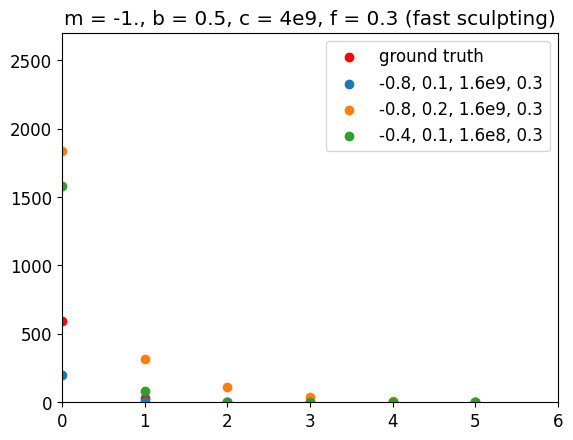

In [30]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[6909].transit_multiplicities)), recovery.iloc[6909].transit_multiplicities, label='-0.8, 0.1, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[7459].transit_multiplicities)), recovery.iloc[7459].transit_multiplicities, label='-0.8, 0.2, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[18759].transit_multiplicities)), recovery.iloc[18759].transit_multiplicities, label='-0.4, 0.1, 1.6e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,2700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

The green functional no-sculpting model has 6.5% multi:single ratio; compared to the blue sculpting model with 5.8% multi:single ratio, this is sensible.

What are the favored models' intact fractions?

In [343]:
full_good = good_models.merge(recovery, how='inner', left_on=['m','b','c','f'], right_on=['ms','bs','cs','fs'])
print(min(full_good.intact_fracs), max(full_good.intact_fracs))

0.0 0.0133254444700992


In [344]:
truth.loc[(np.round(truth.ms, 1) == -1.) & (truth.bs == 0.5) & (np.round(truth.cs, -9) == 4e9) & (np.round(truth.fs,1) == 0.3)]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
692,-1.0,0.5,3.981072e+09,0.3,"[591.3, 31.2, 0.0, 0.0, 0.0, 0.0]","[1190.1, 111.3, 0.0, 0.0, 0.0, 0.0]",0.0,0.3,-279.577052,-174.798261,-343.833663


Plot these models

-1.0 0.30000000000000004 398107171.0 0.3
-1.0 0.5 3981071706.0 0.3


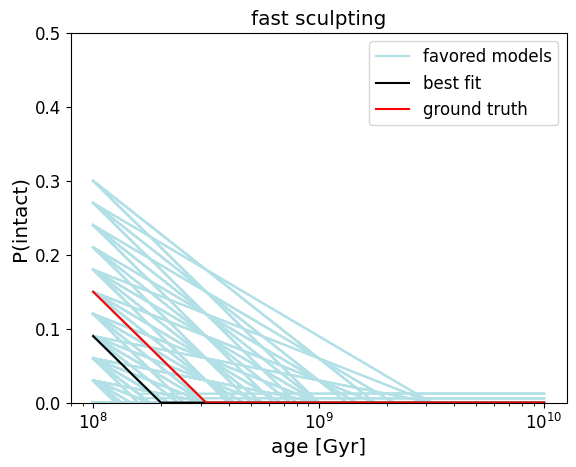

In [345]:
# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, label='favored models', alpha=1)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, alpha=1,
                path_effects=[pe.Stroke(linewidth=1, foreground='white'), pe.Normal()])
    label_flag = False  

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.title(f'm = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.title('fast sculpting')
plt.legend()
plt.savefig(path+'figures/inj-rec-fast-models-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

In [603]:
329/(6*11*11)

0.453168044077135

In [607]:
good_models_m_c

,m,b,c,f,injection_transit_multiplicities,logL
2,-1.0,0.0,1.000000e+08,0.3,"[611.1, 31.2, 0.0, 0.0, 0.0, 0.0]",-7.061195
12,-1.0,0.0,1.584893e+08,0.3,"[632.1, 32.4, 0.0, 0.0, 0.0, 0.0]",-7.123481
22,-1.0,0.0,2.511886e+08,0.3,"[630.0, 36.0, 0.0, 0.0, 0.0, 0.0]",-6.994674
32,-1.0,0.0,3.981072e+08,0.3,"[616.5, 38.699999999999996, 0.0, 0.0, 0.0, 0.0]",-7.040230
42,-1.0,0.0,6.309573e+08,0.3,"[604.5, 37.5, 0.0, 0.0, 0.0, 0.0]",-7.045327
...,...,...,...,...,...,...
6112,0.0,0.0,1.584893e+09,0.3,"[600.3, 34.8, 0.0, 0.0, 0.0, 0.0]",-7.046985
6122,0.0,0.0,2.511886e+09,0.3,"[604.8, 37.199999999999996, 0.0, 0.0, 0.0, 0.0]",-7.027012
6132,0.0,0.0,3.981072e+09,0.3,"[605.4, 37.5, 0.0, 0.0, 0.0, 0.0]",-7.050123
6142,0.0,0.0,6.309573e+09,0.3,"[630.3, 36.9, 0.0, 0.0, 0.0, 0.0]",-7.042920


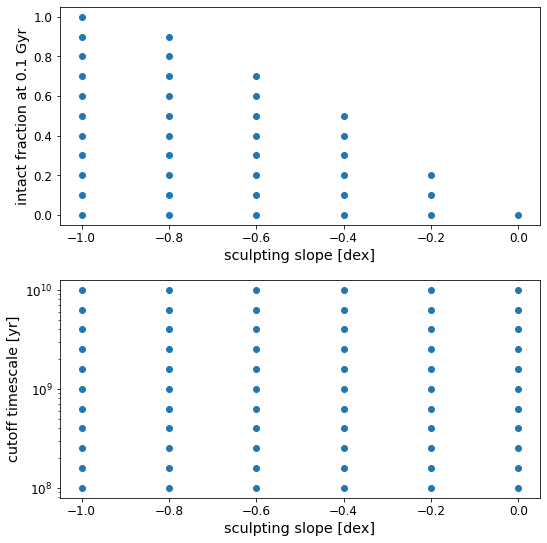

In [15]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))
f.tight_layout(pad=3.)

good_models_m_b = good_models.drop_duplicates(subset=['m','b'])
ax1.scatter(good_models_m_b.m, good_models_m_b.b)
ax1.set_xlabel('sculpting slope [dex]')
ax1.set_ylabel('intact fraction at 0.1 Gyr')
ax1.set_xlim([-1.05, 0.05])
ax1.set_ylim([-0.05, 1.05])

good_models_m_c = good_models.drop_duplicates(subset=['m','c'])
ax2.scatter(good_models_m_c.m, good_models_m_c.c)
ax2.set_xlabel('sculpting slope [dex]')
ax2.set_ylabel('cutoff timescale [yr]')
ax2.set_xlim([-1.05, 0.05])
ax2.set_yscale('log')

#plt.savefig(path+'figures/inj-rec-fast-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

#### Normalizing no-sculpting models, which are fewer than the others

In [30]:
model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.f == 0.1)]

,m,b,c,f,logL
30250,0.0,0.0,1.000000e+08,0.1,-276.863070
30251,0.0,0.0,1.000000e+08,0.1,-276.863070
30252,0.0,0.0,1.000000e+08,0.1,-276.863070
30300,0.0,0.0,1.584893e+08,0.1,-271.592268
30301,0.0,0.0,1.584893e+08,0.1,-271.592268
...,...,...,...,...,...
36201,0.0,1.0,6.309573e+09,0.1,-335.635030
36202,0.0,1.0,6.309573e+09,0.1,-335.635030
36250,0.0,1.0,1.000000e+10,0.1,-332.059695
36251,0.0,1.0,1.000000e+10,0.1,-332.059695


Ope! Looks like I've lost a few differing cutoff timescale files for the case of no sculpting. Fortunately, this edge case means that the logL should be the same regardless of cutoff time. 

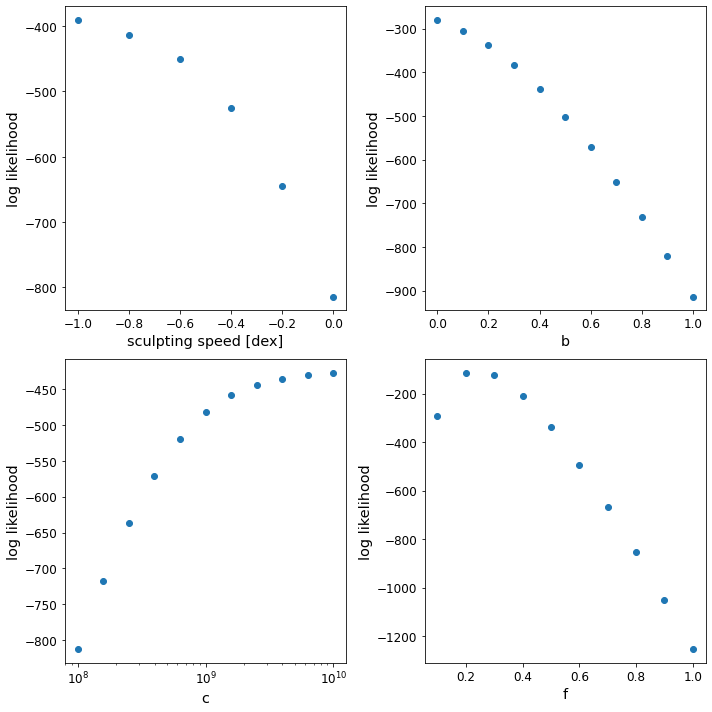

In [16]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(model_logLs.m.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(model_logLs.c.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

In [17]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL.mean())
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL.mean())


-718.0011125215544
-636.670689663753


It seems like no matter the ground truth, I always favor the second cutoff threshold. Why is that? This subset of models has the same number of records (eg. no dropped data) and similar mins and maxes to adjacent models (ie. the subsequent cutoff threshold of 2.5e8 yrs). So, what gives? 

     m    b            c    f  \
0 -1.0  0.0  100000000.0  0.1   
1 -1.0  0.0  100000000.0  0.2   
2 -1.0  0.0  100000000.0  0.3   
3 -1.0  0.0  100000000.0  0.4   
4 -1.0  0.0  100000000.0  0.5   

                    injection_transit_multiplicities        logL  
0                  [204.3, 11.8, 0.0, 0.0, 0.0, 0.0] -291.412640  
1                  [408.6, 23.6, 0.0, 0.0, 0.0, 0.0]  -55.465881  
2                  [611.1, 31.2, 0.0, 0.0, 0.0, 0.0]   -7.061195  
3  [810.8000000000001, 48.800000000000004, 0.0, 0...  -35.019123  
4                 [1013.5, 61.0, 0.0, 0.0, 0.0, 0.0] -105.185728  


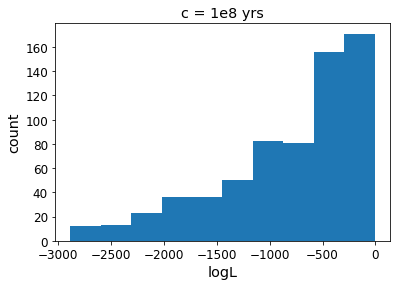

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                  injection_transit_multiplicities        logL  
10  [204.70000000000002, 11.0, 0.0, 0.0, 0.0, 0.0] -291.394054  
11  [409.40000000000003, 22.0, 0.0, 0.0, 0.0, 0.0]  -55.447296  
12               [632.1, 32.4, 0.0, 0.0, 0.0, 0.0]   -7.123481  
13               [816.0, 45.2, 0.0, 0.0, 0.0, 0.0]  -35.000537  
14              [1020.0, 56.5, 0.0, 0.0, 0.0, 0.0] -105.167142  


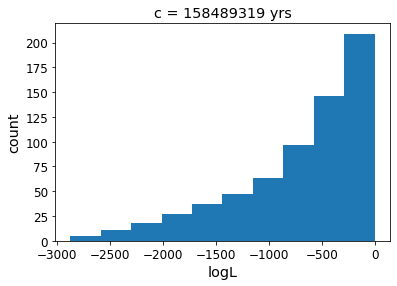

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                   injection_transit_multiplicities        logL  
20                [205.0, 10.5, 0.0, 0.0, 0.0, 0.0] -292.136830  
21                [410.0, 21.0, 0.0, 0.0, 0.0, 0.0]  -55.890072  
22                [630.0, 36.0, 0.0, 0.0, 0.0, 0.0]   -6.994674  
23  [809.2, 50.400000000000006, 0.0, 0.0, 0.0, 0.0]  -34.843313  
24               [1011.5, 63.0, 0.0, 0.0, 0.0, 0.0] -104.709918  


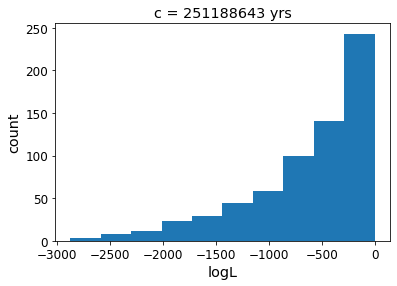

In [540]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


In [16]:
import matplotlib.ticker as tick

def y_fmt(x, y):
    return '{:2.2e}'.format(x).replace('e', 'x10^')
    #return 

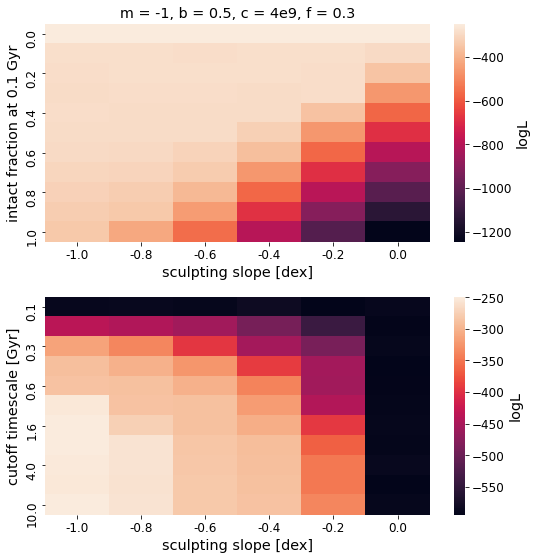

In [78]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))
f.tight_layout(pad=3.)

### 1
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood

#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax1)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title('m = -1, b = 0.5, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
#ax1.grid()

### 2
piv = model_logLs.groupby(['m','c']).median('logL').reset_index()
piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax2)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))
#ax2.grid()

#plt.savefig(path+'figures/inj-rec-fast-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

Instead of a gradient, let's just show models that have at least one realization that is within one delta_logL of the best_logL. The easiest way to do this is to impose a vmin and do binary colors.

In [77]:
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL]

,m,c,b,f,logL
0,-1.0,1.000000e+08,1.0,1.0,-7.061195
1,-1.0,1.584893e+08,1.0,1.0,-7.123481
2,-1.0,2.511886e+08,1.0,1.0,-6.994674
3,-1.0,3.981072e+08,1.0,1.0,-7.040230
4,-1.0,6.309573e+08,1.0,1.0,-7.045327
...,...,...,...,...,...
61,0.0,1.584893e+09,1.0,1.0,-7.046985
62,0.0,2.511886e+09,1.0,1.0,-7.027012
63,0.0,3.981072e+09,1.0,1.0,-7.050123
64,0.0,6.309573e+09,1.0,1.0,-7.042920


<>:54: SyntaxWarning: invalid escape sequence '\D'
<>:55: SyntaxWarning: invalid escape sequence '\D'
<>:54: SyntaxWarning: invalid escape sequence '\D'
<>:55: SyntaxWarning: invalid escape sequence '\D'
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_56992/1957477103.py:54: SyntaxWarning: invalid escape sequence '\D'
  white_patch = mpatches.Patch(color='powderblue', label=f'favored: $\Delta logL <= {int(delta_logL)}$')
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_56992/1957477103.py:55: SyntaxWarning: invalid escape sequence '\D'
  black_patch = mpatches.Patch(color='steelblue', label=f'unfavored: $\Delta logL > {int(delta_logL)}$')


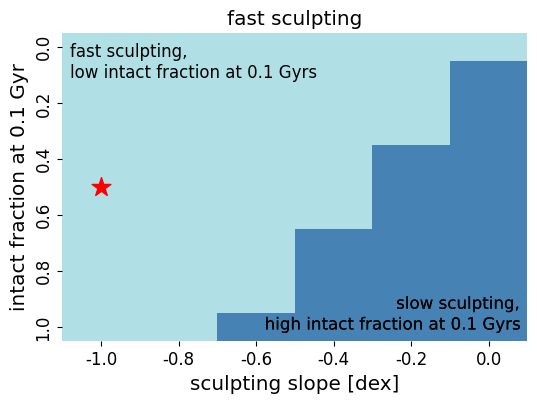

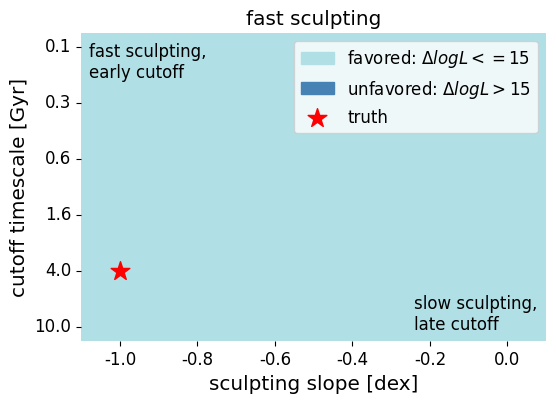

In [350]:
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = model_logLs.groupby(['m','b']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="b",columns="m",values="logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)
    
#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax1) #cmap=ListedColormap(['black']), mask=(special_data == 1))#, vmin=best_logL-delta_logL)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -1, b = 0.5, c = 4e9, f = 0.3')
ax1.set_title('fast sculpting')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
ax1.scatter(0.5, 5.5, color='red', marker='*', s=200, label='truth')

ax1.text(0.1, 1.5, "fast sculpting,\nlow intact fraction at 0.1 Gyrs", fontsize='large', wrap=True)
ax1.text(5.9, 10.5, "slow sculpting,\nhigh intact fraction at 0.1 Gyrs", fontsize='large', wrap=True,
        horizontalalignment='right', path_effects=[pe.Stroke(linewidth=0, foreground='white'), pe.Normal()])

plt.savefig(path+'figures/inj-rec-fast-2d_a-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="c",columns="m",values="logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), ax=ax2, 
            cmap=ListedColormap(['powderblue']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax2)# cmap=ListedColormap(['black']), mask=(special_data == 1))#vmin=best_logL-delta_logL)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))
ax2.set_title('fast sculpting')
ax2_truth = ax2.scatter(0.5, 8.5, color='red', marker='*', s=200, label='truth')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label=f'favored: $\Delta logL <= {int(delta_logL)}$')
black_patch = mpatches.Patch(color='steelblue', label=f'unfavored: $\Delta logL > {int(delta_logL)}$')

#ax1.legend(handles=[white_patch, black_patch, ax2_truth], loc='upper left')
ax2.text(0.1, 1.5, "fast sculpting,\nearly cutoff", fontsize='large', wrap=True)
ax2.text(4.3, 10.5, "slow sculpting,\nlate cutoff", fontsize='large', wrap=True)

plt.legend(handles=[white_patch, black_patch, ax2_truth], loc='upper right')
plt.savefig(path+'figures/inj-rec-fast-2d_b-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

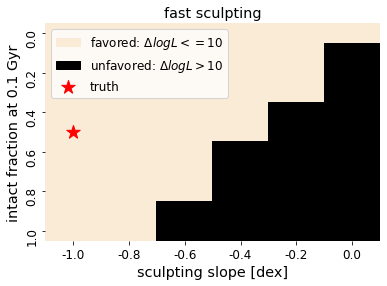

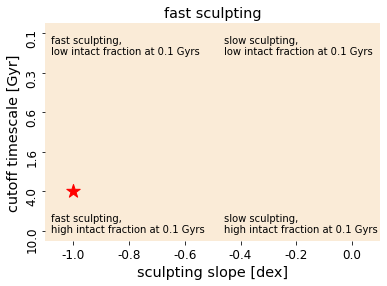

In [66]:
f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = model_logLs.groupby(['m','b']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)
    
#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), ax=ax1, cmap=ListedColormap(['black','antiquewhite']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax1) #cmap=ListedColormap(['black']), mask=(special_data == 1))#, vmin=best_logL-delta_logL)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -1, b = 0.5, c = 4e9, f = 0.3')
ax1.set_title('fast sculpting')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
ax1_truth = ax1.scatter(0.5, 5.5, color='red', marker='*', s=200, label='truth')
plt.legend(handles=[white_patch, black_patch, ax1_truth], loc='upper left')
plt.savefig(path+'figures/inj-rec-fast-2d_a.png', facecolor='white', bbox_inches='tight')
plt.show()

f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
### 2
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), ax=ax2, cmap=ListedColormap(['antiquewhite']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax2)# cmap=ListedColormap(['black']), mask=(special_data == 1))#vmin=best_logL-delta_logL)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
ax2.set_title('fast sculpting')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))
ax2_truth = plt.scatter(0.5, 8.5, color='red', marker='*', s=200, label='truth')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='antiquewhite', label=f'favored: $\Delta logL <= {int(delta_logL)}$')
black_patch = mpatches.Patch(color='black', label=f'unfavored: $\Delta logL > {int(delta_logL)}$')

plt.text(0.1, 1.5, "fast sculpting,\nlow intact fraction at 0.1 Gyrs", fontsize='medium', wrap=True)
plt.text(3.2, 1.5, "slow sculpting,\nlow intact fraction at 0.1 Gyrs", fontsize='medium', wrap=True)
plt.text(0.1, 10.5, "fast sculpting,\nhigh intact fraction at 0.1 Gyrs", fontsize='medium', wrap=True)
plt.text(3.2, 10.5, "slow sculpting,\nhigh intact fraction at 0.1 Gyrs", fontsize='medium', wrap=True)
plt.savefig(path+'figures/inj-rec-fast-2d_b.png', facecolor='white', bbox_inches='tight')
plt.show()

Here's the old way, in case I need to return to it.

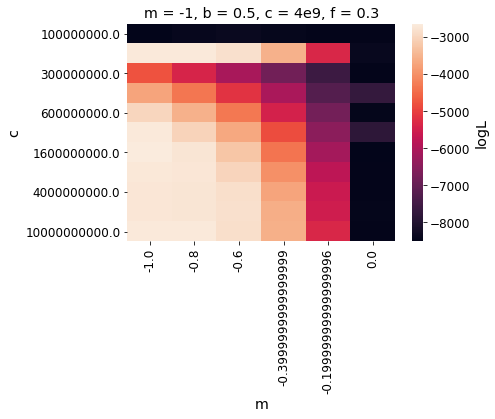

In [37]:
"""
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(-8), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()
"""

It looks like we recover a cutoff time of 2.5 Gyrs instead of 4 Gyrs, as well as {m=0, b=0.5} instead of {m=-1, b=0.5}, although the latter is a close one, and in general the 1D posteriors show that m=0 is generally bad.

The mystery around why the models seem to love the second cutoff threshold continues to deepen, as I show in the first three attached plots for the fake ground truth of fast sculpting (m = -1, b = 0.5, c = 4e9, f = 0.3). The middle plot of 1.6e8 years shows a shorter tail than the adjacent cutoff times. 

EDIT: Actually, I don’t think this is as big a mystery as it seemed; as shown by the two other ground truths below. The only question is why all three ground truths favor a cutoff time that is way younger than the median age of the stellar sample…which suggests that no matter what’s real, sculpting is always going to appear to be very short-lived.

I am also finding that when I examine the raw simulation outputs from HPG, sometimes some models get the exact same transit multiplicity. Either this is some coincidence, or some as yet undiscovered bug, or some copying of data happened in the distributed HPG job. This happens only a few times, as far as I can tell. My ad hoc solution is to manually identify the original correct record and drop the incorrect ones, but I can only identify them as they come to my attention (which is when a spuriously copied multiplicity happens to be better than the other 29 draws and elevates a model beyond where it should be). I have switched to taking the median out of each 30ish samples instead of the max, and that seems to be a little more robust, but the weird favoring of the second cutoff time still persists.

Finally, the ground truth plot says a cutoff of 4e9, but since that model’s slope takes us below zero well before then, that is as good as any model with a cutoff time after that zero point. So, perhaps I should have chosen a more sensible ground truth.

#### Model 3: m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)


Before we proceed, let's take a detour to check that the transit multiplicity yields for different models are different in the ways that we expect. For example, a model with more sculpting and/or fewer initially intact systems should have fewer multis.

In [333]:
tm_fiducial = truth.loc[(truth.ms == -0.6) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

3902    [663.6, 158.1, 68.7, 23.7, 9.0, 0.0]
Name: transit_multiplicities, dtype: object

In [334]:
test_recovery = recovery.loc[(recovery.ms == -0.6) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities

Both in count and relative to singles, there are fewer multis represented by the orange dots than the blue/red dots. Anyway, let's continue to check out injection-recovery for medium sculpting models.

In [335]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median/max logL for each model
                    median_logL = np.nanmax(logLs) # np.median(logLs)
                    median_arg = np.argmax(logLs) # np.argmax(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except Exception as e:
                    all_logLs.append(0.)
                    print(e, cube[0], cube[1], cube[2], f)
                    
                if ((np.round(cube[0],1)==-0.6) & (np.round(cube[1],1)==1.) & (np.round(cube[2],-8)==1e9) & (np.round(f,1)==0.3)):
                    print(len(tm_recovery))
                    print(np.max(logLs) - np.min(logLs))
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

30
4.415073394716458


Identify best and good models

In [336]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -0.6) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = best_logL - ground_truth.logL.to_list()[0]
print(delta_logL)
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == -0.6) & (np.round(recovery.bs,1) == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].logLs)
print(delta_logL)
print(np.max(recovery.loc[(np.round(recovery.ms, 1) == -0.6) & (np.round(recovery.bs,1) == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].logLs) - np.min(recovery.loc[(np.round(recovery.ms, 1) == -0.6) & (np.round(recovery.bs,1) == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].logLs))
delta_logL = 15.

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models)

Best model:          m    b            c    f                                    tm  \
4442 -0.4  0.7  630957344.0  0.3  [644.1, 156.6, 67.2, 26.4, 8.4, 0.0]   

           logL  
4442 -15.665999  
Ground truth:          m    b             c    f  \
3572 -0.6  1.0  1.000000e+09  0.3   

                                                     tm       logL  
3572  [640.8, 168.29999999999998, 66.3, 27.0, 9.0, 0.0] -16.155779  
0.48978042141682643
4.200424969240371
15.033007266225432
Some models between best model and ground truth: 
        m    b             c    f  \
332  -1.0  0.3  1.000000e+08  0.3   
333  -1.0  0.3  1.000000e+08  0.4   
442  -1.0  0.4  1.000000e+08  0.3   
552  -1.0  0.5  1.000000e+08  0.3   
562  -1.0  0.5  1.584893e+08  0.3   
...   ...  ...           ...  ...   
6662  0.0  0.5  1.584893e+09  0.3   
6672  0.0  0.5  2.511886e+09  0.3   
6682  0.0  0.5  3.981072e+09  0.3   
6692  0.0  0.5  6.309573e+09  0.3   
6702  0.0  0.5  1.000000e+10  0.3   

                      

Plot these models

In [233]:
good_models.loc[(np.round(good_models.c, -7) == 1.6e8) & (np.round(good_models.f,1) == 0.3)]

,m,b,c,f,tm,logL
562,-1.0,0.5,158489319.0,0.3,"[629.4, 143.7, 55.199999999999996, 22.5, 7.8, ...",-19.347302
672,-1.0,0.6,158489319.0,0.3,"[646.8, 156.0, 64.5, 26.4, 6.6, 0.3]",-16.384691
782,-1.0,0.7,158489319.0,0.3,"[655.1999999999999, 183.6, 91.8, 30.9, 8.7, 0.6]",-21.803014
1772,-0.8,0.5,158489319.0,0.3,"[632.4, 143.4, 66.89999999999999, 28.2, 7.5, 0.0]",-17.216966
1882,-0.8,0.6,158489319.0,0.3,"[651.0, 164.1, 75.6, 29.099999999999998, 9.0, ...",-17.178402
1992,-0.8,0.7,158489319.0,0.3,"[665.6999999999999, 201.9, 86.7, 30.5999999999...",-25.143146
2872,-0.6,0.4,158489319.0,0.3,"[636.9, 126.6, 54.3, 18.599999999999998, 6.899...",-22.361183
2982,-0.6,0.5,158489319.0,0.3,"[649.8, 157.5, 65.39999999999999, 29.4, 7.1999...",-16.215028
3092,-0.6,0.6,158489319.0,0.3,"[641.4, 175.79999999999998, 74.1, 36.6, 9.6, 0.3]",-19.609881
4082,-0.4,0.4,158489319.0,0.3,"[631.1999999999999, 146.1, 60.599999999999994,...",-17.968031


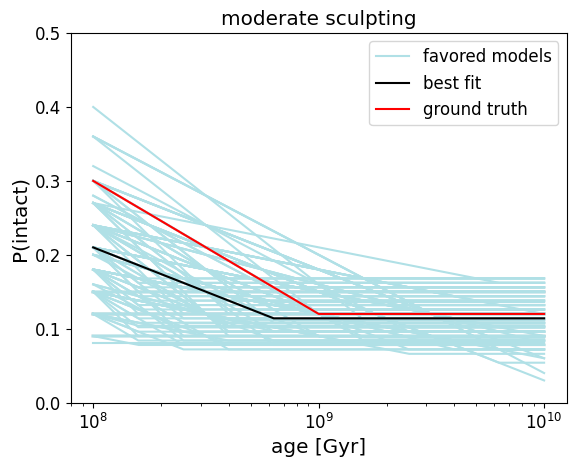

In [337]:
x = np.logspace(8, 10, 1000)

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, label='favored models', alpha=1)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, alpha=1)

    if build_models(x, m, b, c, f)[-1] > 0.21:
        print(build_models(x, m, b, c, f)[-1], m, b, c, f)
    label_flag = False  
    
# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.title(f'm = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)')
plt.title('moderate sculpting')
plt.legend()
plt.savefig(path+'figures/inj-rec-moderate-models-asymmetric.png', facecolor='white', bbox_inches='tight')

plt.show()

Why are the favored models' intact fractions not all bundled together? What's with the outliers? To check, let's plot the transit multiplicities. 

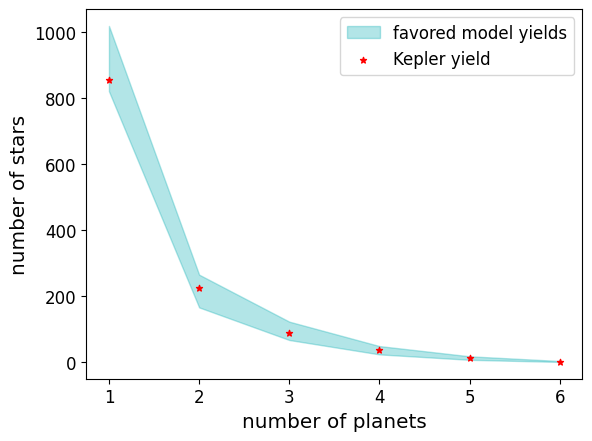

In [100]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

yield_max = []
yield_min = []
for temp_list in zip_longest(*good_models.tm):
    yield_max.append(np.max(temp_list))
    yield_min.append(np.min(temp_list))
    
plt.fill_between(np.arange(7)[1:], yield_max, yield_min, color='#03acb1', alpha=0.3, label='favored model yields')
plt.scatter(np.arange(7)[1:], ground_truth.reset_index().tm[0], color='r', marker='*', s=20, label='Kepler yield')
plt.xlabel('number of planets')
plt.ylabel('number of stars')
plt.legend()
#plt.savefig(path+'figures/good-yields.png', facecolor='white', bbox_inches='tight')
plt.show()


What are the favored models' intact fractions?

In [141]:
full_good = good_models.merge(recovery, how='inner', left_on=['m','b','c','f'], right_on=['ms','bs','cs','fs'])
print(min(full_good.intact_fracs), max(full_good.intact_fracs))

0.1190833525744631 0.2013334102978527


What is the injected ground truth model's intact fraction?

In [235]:
truth.loc[(truth.ms == -0.6) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)]


,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
3902,-0.6,1.0,1.000000e+09,0.3,"[663.6, 158.1, 68.7, 23.7, 9.0, 0.0]","[1047.3, 277.2, 157.79999999999998, 105.6, 52....",0.121094,0.178906,-47.430247,-40.189858,-153.410743


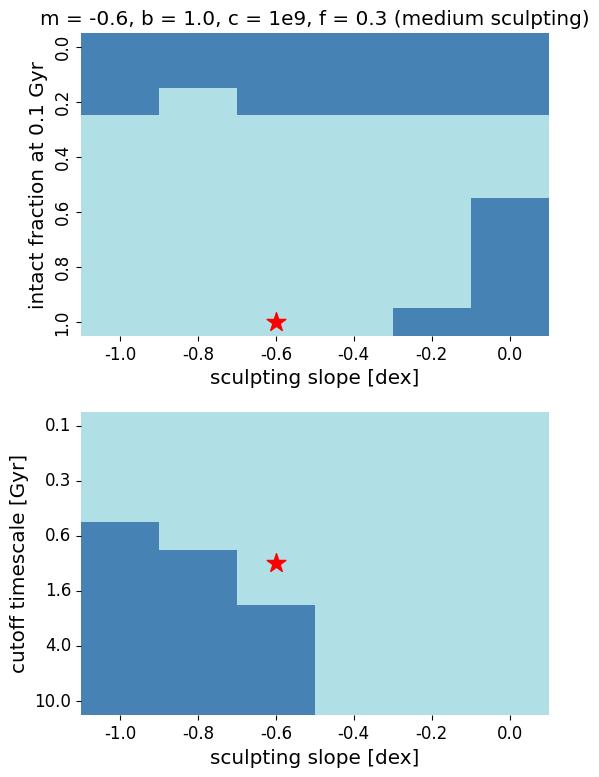

In [266]:
from matplotlib.colors import ListedColormap

f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(6, 8))
f.tight_layout(pad=3.)

### 1
piv = model_logLs.groupby(['m','b']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="b",columns="m",values="logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)
    
#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax1) #cmap=ListedColormap(['black']), mask=(special_data == 1))#, vmin=best_logL-delta_logL)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title(f'm = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
ax1.scatter(2.5, 10.5, color='red', marker='*', s=200, label='truth')

### 2
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="c",columns="m",values="logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax2)# cmap=ListedColormap(['black']), mask=(special_data == 1))#vmin=best_logL-delta_logL)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))
ax2.scatter(2.5, 5.5, color='red', marker='*', s=200, label='truth')


plt.savefig(path+'figures/inj-rec-moderate-2d-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

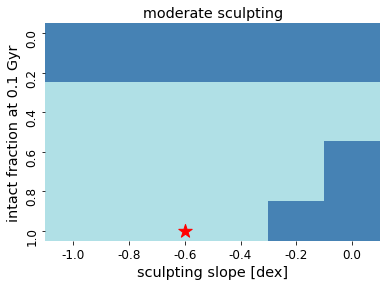

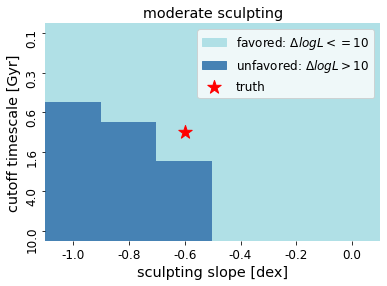

In [201]:
f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = model_logLs.groupby(['m','b']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)
    
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='powderblue', label=f'favored: $\Delta logL <= {int(delta_logL)}$')
black_patch = mpatches.Patch(color='steelblue', label=f'unfavored: $\Delta logL > {int(delta_logL)}$')

#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax1) #cmap=ListedColormap(['black']), mask=(special_data == 1))#, vmin=best_logL-delta_logL)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title('moderate sculpting')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
ax1.scatter(2.5, 10.5, color='red', marker='*', s=200, label='truth')
plt.savefig(path+'figures/inj-rec-moderate-2d_a-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
### 2
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#special_data = np.ma.masked_where(piv>=best_logL-delta_logL, piv)

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
            #cbar_kws={'label': 'logL'}, ax=ax2)# cmap=ListedColormap(['black']), mask=(special_data == 1))#vmin=best_logL-delta_logL)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))
ax2_truth = ax2.scatter(2.5, 5.5, color='red', marker='*', s=200, label='truth')
ax2.set_title('moderate sculpting')

plt.legend(handles=[white_patch, black_patch, ax2_truth], loc='upper right')

plt.savefig(path+'figures/inj-rec-moderate-2d_b-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

#### Model 4: m = 0, b = 0.5, c = 1e9, f = 0.3 (no sculpting)


In [359]:
tm_fiducial = truth.loc[(truth.ms == 0.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

7262    [679.5, 200.4, 92.39999999999999, 35.699999999...
Name: transit_multiplicities, dtype: object

In [360]:
test_recovery = recovery.loc[(recovery.ms == 0.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)]
#test_recovery

In [361]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median/max logL for each model
                    median_logL = np.nanmax(logLs) # np.median(logLs)
                    median_arg = np.argmax(logLs) # argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
                if ((np.round(cube[0],1)==0.) & (np.round(cube[1],1)==0.5) & (np.round(cube[2],-8)==1e9) & (np.round(f,1)==0.3)):
                    print(len(tm_recovery))
                    print(np.max(logLs) - np.min(logLs))
                    
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

30
2.9171684168748833


Identify best and good models

In [362]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = 15.

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models)

Best model:          m    b             c    f  \
6662  0.0  0.5  1.584893e+09  0.3   

                                                     tm       logL  
6662  [662.4, 207.29999999999998, 94.5, 36.0, 9.9, 0.0] -16.047788  
Ground truth:          m    b             c    f  \
6652  0.0  0.5  1.000000e+09  0.3   

                                                     tm       logL  
6652  [683.6999999999999, 198.6, 91.8, 32.4, 8.1, 0.... -16.814351  
Some models between best model and ground truth: 
        m    b             c    f  \
333  -1.0  0.3  1.000000e+08  0.4   
442  -1.0  0.4  1.000000e+08  0.3   
443  -1.0  0.4  1.000000e+08  0.4   
552  -1.0  0.5  1.000000e+08  0.3   
662  -1.0  0.6  1.000000e+08  0.3   
...   ...  ...           ...  ...   
6882  0.0  0.7  1.584893e+09  0.3   
6892  0.0  0.7  2.511886e+09  0.3   
6902  0.0  0.7  3.981072e+09  0.3   
6912  0.0  0.7  6.309573e+09  0.3   
6922  0.0  0.7  1.000000e+10  0.3   

                                                   

In [296]:
print("difference between ground truth and best model: ", best_logL - ground_truth.logL)


difference between ground truth and best model:  6652    0.766564
Name: logL, dtype: float64


In [297]:
print(model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])
print(ground_truth)

        m    b             c    f  \
6662  0.0  0.5  1.584893e+09  0.3   

                                                     tm       logL  
6662  [662.4, 207.29999999999998, 94.5, 36.0, 9.9, 0.0] -16.047788  
        m    b             c    f  \
6652  0.0  0.5  1.000000e+09  0.3   

                                                     tm       logL  
6652  [683.6999999999999, 198.6, 91.8, 32.4, 8.1, 0.... -16.814351  


Plot these models

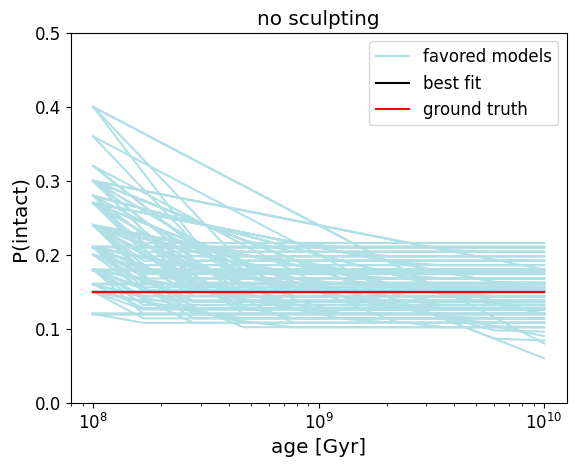

In [363]:
x = np.logspace(8, 10, 10)

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, label='favored models', alpha=1)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, alpha=1)
    label_flag = False  
    
# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.title(f'm = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting)')
plt.title(f'no sculpting')
plt.legend()
plt.savefig(path+'figures/inj-rec-no-models-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

What are the favored models' intact fractions?

In [163]:
full_good = good_models.merge(recovery, how='inner', left_on=['m','b','c','f'], right_on=['ms','bs','cs','fs'])
print(min(full_good.intact_fracs), max(full_good.intact_fracs))

0.1981124451627799 0.2427441699376587


In [164]:
ground_truth.merge(truth, how='inner', left_on=['m','b','c','f'], right_on=['ms','bs','cs','fs'])

,m,b,c,f,tm,logL,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
0,0.0,0.5,1.000000e+09,0.4,"[891.6, 258.0, 111.60000000000001, 48.80000000...",-19.710585,0.0,0.5,1.000000e+09,0.4,"[906.0, 267.2, 123.2, 47.6, 11.600000000000001...","[1379.2, 426.8, 290.0, 196.0, 80.8000000000000...",0.199486,0.200514,-117.524895,-190.394727,-161.107226


<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_56992/3076085626.py:36: SyntaxWarning: invalid escape sequence '\D'
  """


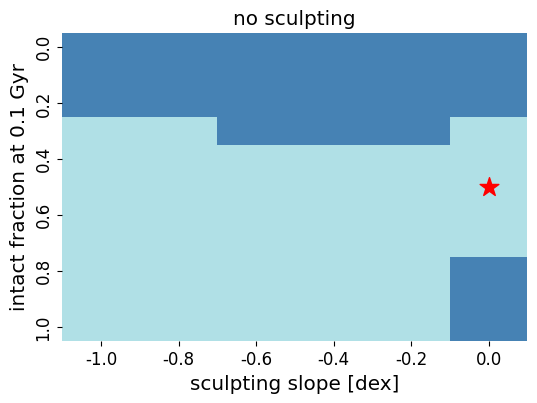

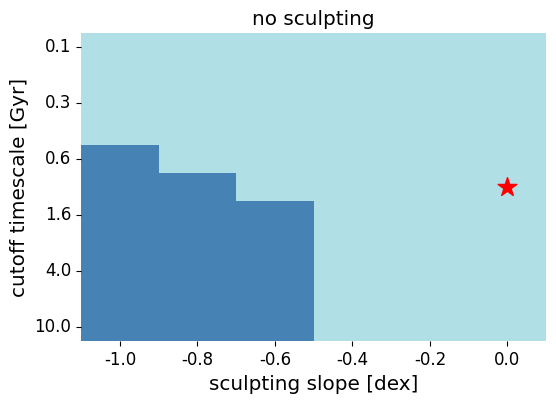

In [364]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = model_logLs.groupby(['m','b']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="b",columns="m",values="logL") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title('no sculpting')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
ax1.scatter(5.5, 5.5, color='red', marker='*', s=200)
plt.savefig(path+'figures/inj-rec-no-2d_a-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
### 2
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="c",columns="m",values="logL") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
ax2_truth = ax2.scatter(5.5, 5.5, color='red', marker='*', s=200, label='truth')
ax2.set_title('no sculpting')

"""
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='antiquewhite', label='favored: $\Delta logL <= 5$')
black_patch = mpatches.Patch(color='black', label='unfavored: $\Delta logL > 5$')

plt.legend(handles=[white_patch, black_patch, ax2_truth])
"""
plt.savefig(path+'figures/inj-rec-no-2d_b-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

Finally, for the no-sculpting model (m = 0, b = 0.5, c = 1e9, f = 0.3), I get the following plots. The question of why delta logL is so small remains, but again, at least all good models result in roughly the same present-day intact fraction.

Perhaps I need to try a very slow (m=-0.2) and long-lived (c=4e9 yrs or something like that).


#### Model 5: slow sculpting (m=-0.2, b=1.0, c=4e9 yrs, f=0.3)

In [373]:
tm_fiducial = truth.loc[(np.round(truth.ms,1) == -0.2) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

6572    [677.6999999999999, 272.4, 120.6, 44.4, 9.9, 0...
Name: transit_multiplicities, dtype: object

In [374]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median/max logL for each model
                    median_logL = np.nanmax(logLs) #np.median(logLs)
                    median_arg = np.argmax(logLs) #argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                    
                if ((np.round(cube[0],1)==-0.2) & (np.round(cube[1],1)==1.) & (np.round(cube[2],-8)==4e9) & (np.round(f,1)==0.3)):
                    print(len(tm_recovery))
                    print(np.max(logLs) - np.min(logLs))
                                    
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

30
3.5568861721757763


Even within the m=-0.2 column, the best cutoff timescales are sub-Gyr, with the ground truth of 4 Gyrs being relatively disfavored. Similarly, the ground truth initial intact fraction of 1.0 is only moderately favored compared to 0.5, even within the m=-0.2 column. 

Finally, let's plot good, best, and ground truth models.

In [375]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(np.round(model_logLs.m, 1) == -0.2) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
#delta_logL = best_logL - ground_truth.logL.to_list()[0]
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == -0.2) & (np.round(recovery.bs,1) == 1.) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)].logLs)
delta_logL = 15.

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f  \
6862  0.0  0.7  630957344.0  0.3   

                                                     tm       logL  
6862  [684.0, 266.7, 116.39999999999999, 47.69999999... -17.362879  
Ground truth:          m    b             c    f  \
6022 -0.2  1.0  3.981072e+09  0.3   

                                                     tm       logL  
6022  [675.6, 279.3, 127.5, 48.3, 12.299999999999999... -18.193794  
Some models between best model and ground truth: 
       m    b            c    f  \
552 -1.0  0.5  100000000.0  0.3   
662 -1.0  0.6  100000000.0  0.3   
772 -1.0  0.7  100000000.0  0.3   
882 -1.0  0.8  100000000.0  0.3   
892 -1.0  0.8  158489319.0  0.3   

                                                    tm       logL  
552  [672.6, 209.7, 92.39999999999999, 36.0, 10.2, ... -30.479588  
662  [659.4, 237.6, 112.5, 44.699999999999996, 8.7,... -20.389339  
772  [662.6999999999999, 270.0, 118.5, 48.6, 11.7, ... -17.594799  
882  [681.3, 27

What are the favored models' intact fractions? 

In [357]:
full_good = good_models.merge(recovery, how='inner', left_on=['m','b','c','f'], right_on=['ms','bs','cs','fs'])
print(min(full_good.intact_fracs), max(full_good.intact_fracs))

0.1485843338720849 0.270907411683214


In [321]:
truth.loc[(np.round(truth.ms, 1) == -0.2) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)]

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
6572,-0.2,1.0,3.981072e+09,0.3,"[677.6999999999999, 272.4, 120.6, 44.4, 9.9, 0...","[893.6999999999999, 408.9, 285.9, 187.5, 86.39...",0.210008,0.089992,-128.53766,-142.491697,-245.701702


In [168]:
print("difference between ground truth and best model: ", best_logL - ground_truth.logL)


difference between ground truth and best model:  6022    0.087647
Name: logL, dtype: float64


In [381]:
full_good.loc[(np.round(full_good.ms, 1) == 0.) & (full_good.bs == 1.) & (np.round(full_good.cs, -7) == 1.6e8) & (np.round(full_good.fs,1) == 0.4)]


,m,b,c,f,tm,logL,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp


In [380]:
full_good

,m,b,c,f,tm,logL,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs,logLs_score,logLs_fpp
0,-1.0,0.5,1.000000e+08,0.3,"[672.6, 209.7, 92.39999999999999, 36.0, 10.2, ...",-30.479588,-1.0,0.5,1.000000e+08,0.3,"[661.1999999999999, 193.2, 87.89999999999999, ...","[991.1999999999999, 320.4, 195.0, 143.1, 67.8,...",0.150095,0.149905,-75.049624,-74.704365,-189.656047
1,-1.0,0.5,1.000000e+08,0.3,"[672.6, 209.7, 92.39999999999999, 36.0, 10.2, ...",-30.479588,-1.0,0.5,1.000000e+08,0.3,"[645.6, 192.6, 86.7, 34.5, 7.5, 1.5]","[1005.3, 323.09999999999997, 174.9, 150.9, 63....",0.149545,0.150455,-75.623888,-69.670307,-195.186190
2,-1.0,0.5,1.000000e+08,0.3,"[672.6, 209.7, 92.39999999999999, 36.0, 10.2, ...",-30.479588,-1.0,0.5,1.000000e+08,0.3,"[663.6, 199.2, 92.1, 33.0, 13.799999999999999,...","[1001.0999999999999, 315.3, 215.1, 144.0, 72.6...",0.149944,0.150056,-78.323826,-79.315348,-192.708459
3,-1.0,0.5,1.000000e+08,0.3,"[672.6, 209.7, 92.39999999999999, 36.0, 10.2, ...",-30.479588,-1.0,0.5,1.000000e+08,0.3,"[651.3, 183.0, 90.6, 39.9, 10.2, 0.89999999999...","[975.5999999999999, 324.0, 202.2, 143.1, 66.3,...",0.150177,0.149823,-77.262252,-73.411415,-195.275056
4,-1.0,0.5,1.000000e+08,0.3,"[672.6, 209.7, 92.39999999999999, 36.0, 10.2, ...",-30.479588,-1.0,0.5,1.000000e+08,0.3,"[643.5, 202.2, 82.8, 36.0, 11.1, 1.5]","[980.0999999999999, 314.09999999999997, 202.5,...",0.150048,0.149952,-79.670251,-74.311416,-201.842899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.9,1.000000e+10,0.3,"[697.1999999999999, 311.4, 144.29999999999998,...",-26.074064,0.0,0.9,1.000000e+10,0.3,"[689.6999999999999, 331.2, 154.5, 64.2, 15.299...","[824.6999999999999, 495.9, 348.0, 241.2, 118.1...",0.270418,0.029582,-202.005214,-226.983749,-322.481138
1046,0.0,0.9,1.000000e+10,0.3,"[697.1999999999999, 311.4, 144.29999999999998,...",-26.074064,0.0,0.9,1.000000e+10,0.3,"[715.8, 326.09999999999997, 162.9, 70.5, 18.0,...","[850.8, 493.79999999999995, 347.4, 246.8999999...",0.270639,0.029361,-206.715105,-239.850117,-318.522906
1047,0.0,0.9,1.000000e+10,0.3,"[697.1999999999999, 311.4, 144.29999999999998,...",-26.074064,0.0,0.9,1.000000e+10,0.3,"[700.1999999999999, 306.0, 157.79999999999998,...","[847.5, 479.7, 349.2, 232.5, 120.6, 20.7]",0.269726,0.030274,-192.041834,-219.075577,-307.717274
1048,0.0,0.9,1.000000e+10,0.3,"[697.1999999999999, 311.4, 144.29999999999998,...",-26.074064,0.0,0.9,1.000000e+10,0.3,"[707.6999999999999, 324.0, 162.9, 61.8, 19.2, ...","[826.8, 497.7, 367.8, 246.89999999999998, 122....",0.270254,0.029746,-201.313745,-231.433131,-315.239649


offender:  -0.19999999999999996 1.0 158489319.0 0.3
offender:  0.0 1.0 158489319.0 0.4


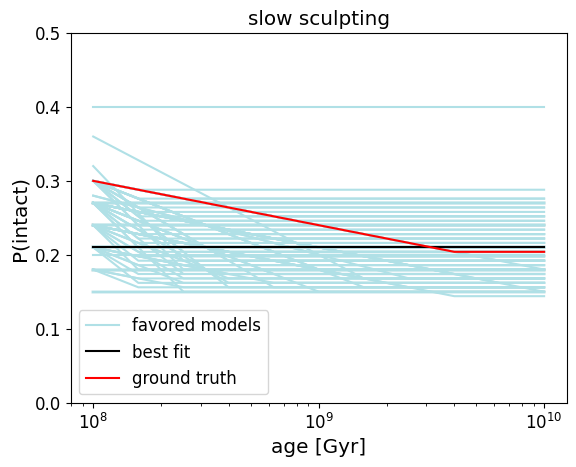

In [383]:
x = np.logspace(8, 10, 1000)

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, label='favored models', alpha=1)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='powderblue', zorder=0, alpha=1)
    label_flag = False  
    if build_models(x, m, b, c, f)[-1] > 0.28:
        print("offender: ", m, b, c, f, )
    
# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
#plt.title(f'm=-0.2, b=1.0, c=4e9 yrs, f=0.3 (slow sculpting)')
plt.title(f'slow sculpting')
plt.legend()
plt.savefig(path+'figures/inj-rec-slow-models-asymmetric.png', facecolor='white', bbox_inches='tight')

plt.show()

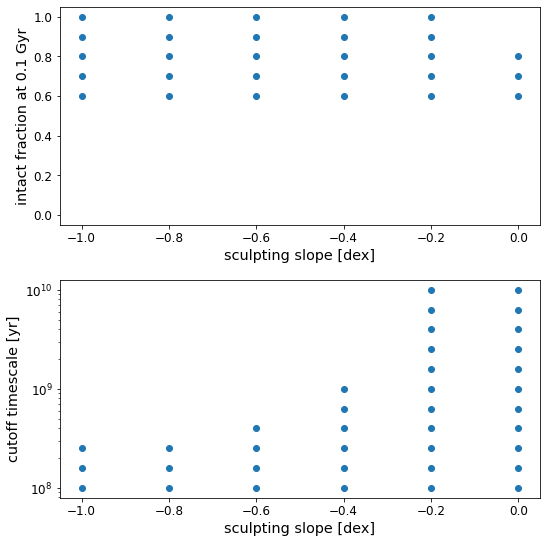

In [588]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))
f.tight_layout(pad=3.)

good_models_m_b = good_models.drop_duplicates(subset=['m','b'])
ax1.scatter(good_models_m_b.m, good_models_m_b.b)
ax1.set_xlabel('sculpting slope [dex]')
ax1.set_ylabel('intact fraction at 0.1 Gyr')
ax1.set_xlim([-1.05, 0.05])
ax1.set_ylim([-0.05, 1.05])

good_models_m_c = good_models.drop_duplicates(subset=['m','c'])
ax2.scatter(good_models_m_c.m, good_models_m_c.c)
ax2.set_xlabel('sculpting slope [dex]')
ax2.set_ylabel('cutoff timescale [yr]')
ax2.set_xlim([-1.05, 0.05])
ax2.set_yscale('log')

plt.savefig(path+'figures/inj-rec-slow-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

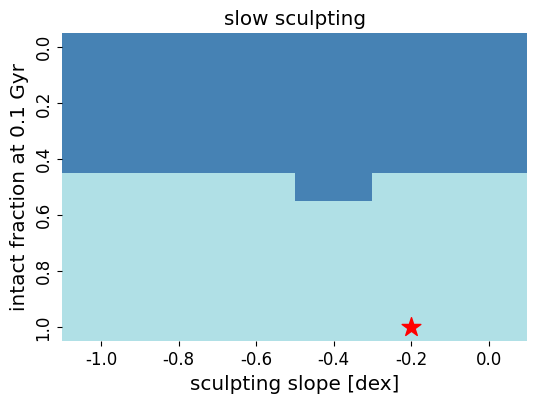

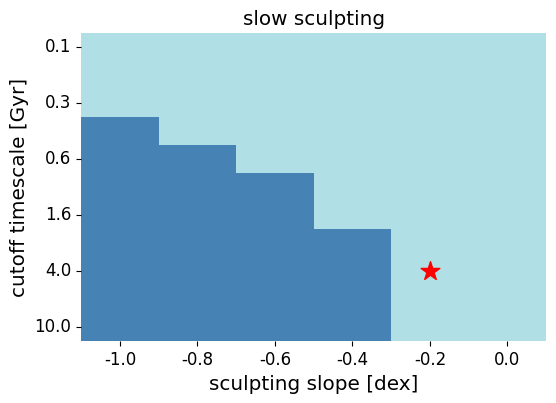

In [305]:
from matplotlib.colors import ListedColormap

f, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4))

### 1
piv = model_logLs.groupby(['m','b']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="b",columns="m",values="logL") # vs logged_normalized_likelihood
    
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), ax=ax1, 
            cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
#ax1.set_title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
ax1.set_title('slow sculpting')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')
ax1.scatter(4.5, 10.5, color='red', marker='*', s=200, label='truth')
plt.savefig(path+'figures/inj-rec-slow-2d_a-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

### 2
f, ((ax2)) = plt.subplots(1, 1, figsize=(6, 4))
piv = model_logLs.groupby(['m','c']).max('logL').reset_index()
piv.loc[piv.logL >= best_logL - delta_logL,'logL'] = 1
piv.loc[piv.logL <  best_logL - delta_logL,'logL'] = 0
piv = piv.pivot(index="c",columns="m",values="logL") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            ax=ax2, cmap=ListedColormap(['steelblue','powderblue']), cbar=False)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
ax2.scatter(4.5, 8.5, color='red', marker='*', s=200, label='truth')
ax2.set_title('slow sculpting')

"""
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

white_patch = mpatches.Patch(color='antiquewhite', label='favored')
black_patch = mpatches.Patch(color='black', label='not favored')
"""
#plt.legend(handles=[white_patch, black_patch])
plt.savefig(path+'figures/inj-rec-slow-2d_b-asymmetric.png', facecolor='white', bbox_inches='tight')
plt.show()

Sarah wanted to know whether the logL distributions were flat when we subset by good models (they should). 

In [340]:
good_models

,m,b,c,f,tm,logL
662,-1.0,0.6,1.000000e+08,0.3,"[687.9, 225.6, 105.6, 40.5, 10.2, 0.0]",-24.131664
772,-1.0,0.7,1.000000e+08,0.3,"[689.1, 274.2, 129.29999999999998, 55.19999999...",-19.783823
882,-1.0,0.8,1.000000e+08,0.3,"[702.0, 290.7, 127.8, 48.3, 13.799999999999999...",-22.218298
1122,-1.0,1.0,2.511886e+08,0.3,"[680.6999999999999, 232.2, 105.0, 41.1, 12.9, ...",-23.596866
1872,-0.8,0.6,1.000000e+08,0.3,"[715.5, 215.7, 113.1, 45.3, 10.799999999999999...",-24.018794
...,...,...,...,...,...,...
6992,0.0,0.8,1.584893e+09,0.3,"[703.8, 288.59999999999997, 135.29999999999998...",-22.913250
7002,0.0,0.8,2.511886e+09,0.3,"[705.6, 285.3, 146.7, 63.3, 17.099999999999998...",-23.031807
7012,0.0,0.8,3.981072e+09,0.3,"[712.8, 285.0, 144.6, 56.699999999999996, 16.2...",-22.392215
7022,0.0,0.8,6.309573e+09,0.3,"[692.4, 297.0, 138.29999999999998, 55.8, 14.1,...",-22.439381


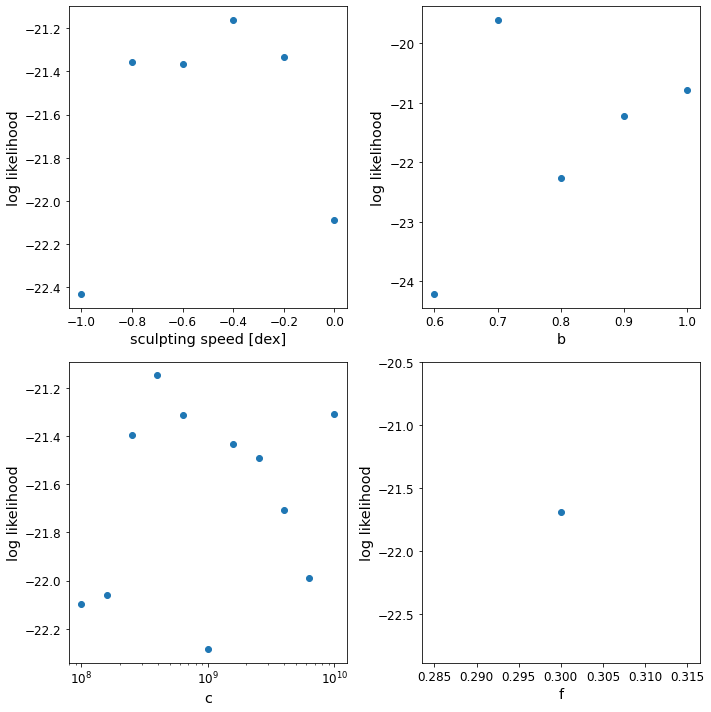

In [335]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = good_models.loc[(np.round(good_models.m, 1) == np.round(cube[0], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = good_models.loc[(np.round(good_models.b,1) == np.round(cube[1], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = good_models.loc[(np.round(good_models.c,0) == np.round(cube[2], 0))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = good_models.loc[(np.round(good_models.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()